In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re

In [30]:
# parameters
data_path = os.path.join('M:\\','rotations','barbara')

fchoicemeta = '220211_2M1F_NaiveChoice_metadata.csv'
mchoicemeta = '220211_2F1M_final_metadata.csv'
huddle_time = 20 # seconds
PPI_floor = 0.75 # value taken from Kim

In [31]:
# metadata
metaF = pd.read_csv(os.path.join(data_path,fchoicemeta))
metaM = pd.read_csv(os.path.join(data_path,mchoicemeta))
metaM = metaM.rename(columns={"File.name": "fname"})
metaF = metaF.rename(columns={"File.name": "fname"})

# data files
allDataFiles = []
allDataFiles += [os.path.join(data_path, each) for each in os.listdir(data_path) if 'Lane' in each]

In [48]:
# support functions

def calc_totals_from_durs(durs,thresh):
    '''
    '''
    use_durs = durs[durs>thresh]
    total_time = np.nansum(use_durs)
    return total_time
    

def calc_PPI(tab,thresh):
    '''
    '''
    
    Rdurs = tab.Contact_Right_stop-tab.Contact_Right_start
    Ldurs = tab.Contact_Left_stop-tab.Contact_Left_start
    Rtot = calc_totals_from_durs(Rdurs,thresh)
    Ltot = calc_totals_from_durs(Ldurs,thresh)
    PPI = (Rtot - Ltot)/(Rtot + Ltot)
    return PPI,Rtot,Ltot

In [50]:
fbase = []
lanes = []
adjlane = []
leftGT = []
rightGT = []
focalsex = []
PPI = []
absPPI = []
winnerside = []

# loop over data files, load, do calculations, grab metadata, make one big table
for i,file in enumerate(allDataFiles):
    fname = os.path.basename(file).strip('.csv')[-20:]
    fbase.append(fname)
    getlane = fname.split('_')
    lane = int(getlane[1][4])
    lanes.append(lane)
    if lane==1 or lane==4:
        adjlane.append(1)
    elif lane==2 or lane==3:
        adjlane.append(2)
    else:
        print('Invalid lane number.')
        break
    if np.isin(metaM.fname,fname).any():
        focalsex.append('M')
        mask = pd.array(np.isin(metaM.fname,fname), dtype="boolean")
        leftGT.append(metaM.Left[np.isin(metaM.fname,fname)].values[0])
        rightGT.append(metaM.Right[np.isin(metaM.fname,fname)].values[0])
    elif np.isin(metaF.fname,fname).any():
        focalsex.append('F')
        leftGT.append(metaF.Left[np.isin(metaF.fname,fname)].values[0])
        rightGT.append(metaF.Right[np.isin(metaF.fname,fname)].values[0])
    else:
        print('File not found in metadata.')
        break
               
    # data
    thisdat = pd.read_csv(file)
    this_PPI,rtot,ltot = calc_PPI(thisdat,huddle_time)
    PPI.append(this_PPI)
    absPPI.append(np.absolute(this_PPI))
    
    if np.absolute(this_PPI) < PPI_floor:
        winnerside.append('none')
    elif this_PPI>0:
        winnerside.append('right')
    else:
        winnerside.append('left')

In [51]:
d = {'fname': fbase, 'lane': lanes, 'adjlane': adjlane, 'leftGT': leftGT, 'rightGT' : rightGT,'focalsex': focalsex,
    'PPI':PPI,'absPPI':absPPI,'winner':winnerside}
df = pd.DataFrame(data=d)
df

,fname,lane,adjlane,leftGT,rightGT,focalsex,PPI,absPPI,winner
0,X201217_Lane1_append,1,1,WT,WT,M,-0.954829,0.954829,left
1,X201217_Lane2_append,2,2,Oxtr-/-,WT,M,0.284248,0.284248,none
2,X210125_Lane1_append,1,1,WT,WT,M,-0.218244,0.218244,none
3,X210125_Lane2_append,2,2,Oxtr-/-,WT,M,0.850527,0.850527,right
4,X210126_Lane1_append,1,1,Oxtr-/-,WT,M,1.000000,1.000000,right
5,X210126_Lane2_append,2,2,WT,WT,M,0.911561,0.911561,right
6,X210126_Lane3_append,3,2,WT,Oxtr-/-,M,0.742183,0.742183,none
7,X210126_Lane4_append,4,1,WT,WT,M,0.919426,0.919426,right
8,X210513_Lane3_append,3,2,Oxtr-/-,WT,M,0.973030,0.973030,right
9,X210513_Lane4_append,4,1,WT,WT,M,-0.682883,0.682883,none


<AxesSubplot: xlabel='adjlane', ylabel='Count'>

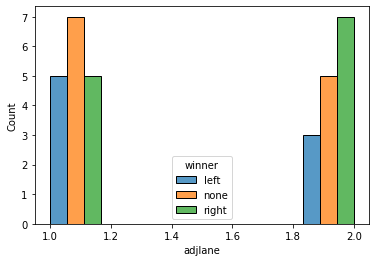

In [59]:
sns.histplot(data=df, x="adjlane", hue="winner",multiple="dodge")

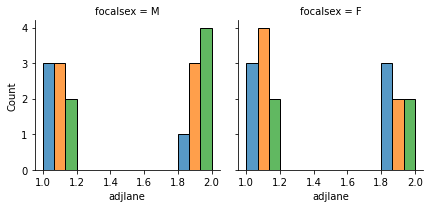

In [62]:
g = sns.FacetGrid(df, col="focalsex")
g.map_dataframe(sns.histplot, x="adjlane", hue="winner", multiple="dodge")
g.add_legend()

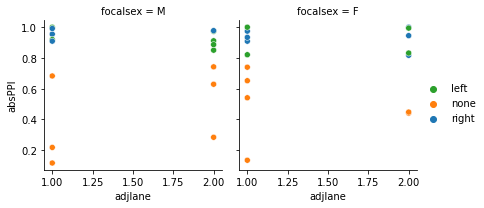

In [64]:
h = sns.FacetGrid(df, col="focalsex")
h.map_dataframe(sns.scatterplot,x="adjlane",y='absPPI',hue='winner')
h.add_legend()